# Do small share of police really draw a third of complaints?
https://www.ft.com/content/141182fc-7727-4af8-a555-5418fa46d09e

    


In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy import optimize

In [65]:
def calculate_poisson(lamdas, quartiles):
    n_total_officers = 43571 ; tot_complaints = 58147; 

    target_total = 0; poisson = []
    while target_total < tot_complaints or target_total == tot_complaints:
        prob_bias = []
        for l,lm in enumerate(lamdas):
            prob_bias.append(np.random.poisson(lm,int(n_total_officers/quartiles)))
        poisson.append(prob_bias)
        target_total = np.sum(np.asarray(poisson))
        
   
    poisson_sum = np.sum(poisson,0)
    sum_complaints_years = np.concatenate(poisson_sum)
    
    sim_complained_ = sum_complaints_years[np.where(sum_complaints_years!=0)[0]]
    sim_unif_prob = ((np.sum(sim_complained_))/n_total_officers/len(poisson))

    srt_sim_id = np.argsort(sim_complained_); srt_sim_id = sim_complained_[srt_sim_id]

    id_number_sim = np.arange(len(sim_complained_));
    percentiles_id_sim = []
    for i in np.arange(0,110,10):
        percentiles_id_sim.append(int(np.percentile(id_number_sim,i)))

    deciles_sums_sim = []
    for i,ii in zip(percentiles_id_sim[:-1],percentiles_id_sim[1:]):
        deciles_sums_sim.append((np.sum(srt_sim_id[i:ii])/ np.sum(srt_sim_id))*100)
    return deciles_sums_sim, len(poisson),sim_unif_prob


officer id with an average 4 complaints per day
0.3579047794909673


58147

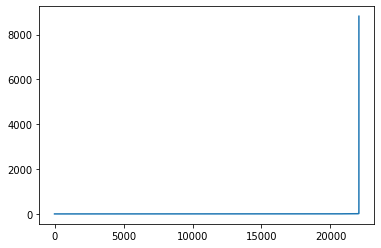

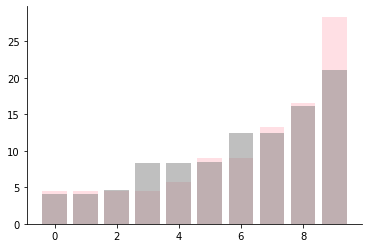

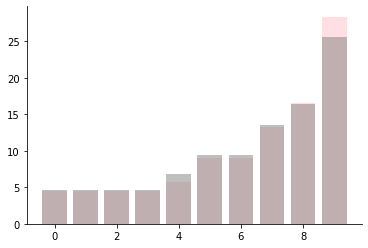

In [66]:
path_to_data = pd.read_csv('/Users/veronikasamborska/Desktop/police/met-police-complaints.csv')
column_names = path_to_data.keys()
case_ref = path_to_data[column_names[0]];
officer_id = path_to_data[column_names[1]]
complaints_per_case = path_to_data[column_names[2]]


id_unq, id_count = np.unique(officer_id, return_counts = True)
srt_id_count = np.argsort(id_count);  
srt_cases = id_count[srt_id_count]; srt_ids = id_unq[srt_id_count]

plt.plot(srt_cases)
print('officer id with an average ' + str(int(srt_cases[-1]/5/365)) + ' complaints per day')
srt_cases = srt_cases[:-2]; srt_ids = srt_ids[:-2] # sort out what's up with the last subject + organisational

'Officers are ranked by number of complaints'


id_number = np.arange(len(id_unq)); percentiles_id = []

for i in np.arange(0,110,10):
        percentiles_id.append(int(np.percentile(id_number,i)))
percentiles_id[-1] =percentiles_id[-1]+1        
'Group into deciles and sum cases'
deciles_sums = []
for i,ii in zip(percentiles_id[:-1],percentiles_id[1:]):
    deciles_sums.append((np.sum(srt_cases[i:ii])/ np.sum(srt_cases))*100)



'Calulcate average probability of an offence per year per officer. Note the data we have is from the last 5 years'
n_total_officers = 32493; # from https://en.wikipedia.org/wiki/Metropolitan_Police
tot_complaints = np.sum(complaints_per_case)
unif_prob = tot_complaints/n_total_officers/5
print(unif_prob)
tot_id_complaint = len(id_unq)
target_total = 0; 
poisson = []
while target_total < tot_complaints or target_total == tot_complaints:
    poisson.append(np.random.poisson(unif_prob,n_total_officers))
    target_total = np.sum(poisson)    

    
sum_complaints_years = np.sum(np.asarray(poisson),0)
sim_complained_ = sum_complaints_years[np.where(sum_complaints_years!=0)[0]]
srt_sim_id = np.argsort(sim_complained_); srt_sim_id = sim_complained_[srt_sim_id]

id_number_sim = np.arange(len(sim_complained_));
percentiles_id_sim = []
for i in np.arange(0,110,10):
    percentiles_id_sim.append(int(np.percentile(id_number_sim,i)))
    
deciles_sums_sim = []
for i,ii in zip(percentiles_id_sim[:-1],percentiles_id_sim[1:]):
    deciles_sums_sim.append((np.sum(srt_sim_id[i:ii])/ np.sum(srt_sim_id))*100)

    
plt.figure() 
plt.bar(np.arange(len(deciles_sums)), deciles_sums, color = 'pink', label = 'real', alpha = 0.5)
plt.bar(np.arange(len(deciles_sums_sim)), deciles_sums_sim, color = 'grey', alpha = 0.5)    
sns.despine()



probs = deciles_sums/np.max(deciles_sums)
simulated, years_to,av  = calculate_poisson(probs, 10)
plt.figure() 
plt.bar(np.arange(len(deciles_sums)), deciles_sums, color = 'pink', label = 'real', alpha = 0.5)
plt.bar(np.arange(len(simulated)), simulated, color = 'grey', alpha = 0.5)    
sns.despine()

np.sum((np.asarray(deciles_sums) - np.asarray(simulated))**2)
tot_complaints


In [67]:
def lambdas_sim(last_perc, quartiles):
    ''''((q-1)*x + last_perc))/q = unif_prob --> rearrange
    unif_prob*q = (q-1)*x + last_perc)
    ((unif_prob*q -last_perc))/(q-1) = x  '''
    unif_prob = 0.3579047794909673
    lamdas = np.zeros(quartiles);
    x = (((quartiles)*unif_prob) - last_perc)/(quartiles-1)
    lamdas[:] = x; lamdas[-1] = last_perc
    return lamdas


In [68]:
def lambdas_sim_graded(a,b, quartiles):
    lamdas = np.random.beta(a, b,quartiles)
    return lamdas


In [69]:
@widgets.interact(last_perc=(0.1, 1))
def plot(last_perc = 0.01):
    quartiles = 10; 
    lamdas = lambdas_sim(last_perc, quartiles)
   
    simulated, years_to,av  = calculate_poisson(lamdas, quartiles)
    fig, ax = plt.subplots(2,1, figsize=(4, 10))
    ax[0].bar(np.arange(len(deciles_sums)), deciles_sums, color = 'pink', label = 'real', alpha = 0.5)
    ax[0].bar(np.arange(len(simulated)), simulated, color = 'grey', alpha = 0.5) 

    sns.despine()
    print('Number of Years to Achieve Total --> ' + str(years_to))
    ax[1].hist(lamdas, color = 'pink', alpha = 0.5) 
    sns.despine()
    print('Average % of Officers that had a complaint ' + str(av))


interactive(children=(FloatSlider(value=0.1, description='last_perc', max=1.0, min=0.1), Output()), _dom_class…

In [70]:
@widgets.interact(a = (0.05,2),b = (0.05,1))
def plot(a = 1, b = 1):
    quartiles = int(32493/10); 
    lamdas = lambdas_sim_graded(a,b, quartiles)
    simulated,years_to,av = calculate_poisson(lamdas, quartiles)
    fig, ax = plt.subplots(2,1, figsize=(4, 10))
    #ax[0].axhline(y=deciles_sums[-1], xmin=0, xmax=9, color = 'red')
    ax[0].bar(np.arange(len(deciles_sums)), deciles_sums, color = 'pink', label = 'real', alpha = 0.5)
    ax[0].bar(np.arange(len(simulated)), simulated, color = 'grey', alpha = 0.5) 

    #ax[0].bar(np.arange(len(deciles_sums)), deciles_sums, color = 'pink', label = 'real', alpha = 0.5)
    hist_, edg = np.histogram(lamdas)
    ax[1].plot(edg[:-1],hist_/quartiles, color = 'pink', alpha = 0.5) 
    
    ax[1].set_xlabel('Probability of Getting a Complaint')
    ax[1].set_ylabel('Proportion of Police Officers')
    sns.despine()
    above_80 = np.where(lamdas>av)[0]
    if len(above_80)>0:
        decile = len(above_80)/quartiles
    else:
        decile = 0
    print("% of Officers with probability of having a complaint above the mean "+ str(np.round(decile*100,5)) + '%')
    print("Top Decile Responsible for " + str(np.round(simulated[-1],1)) + '%')
    #print(np.sum((np.asarray(deciles_sums) - np.asarray(simulated))**2))

    print('Number of Years to Achieve Total --> ' + str(years_to))
    print('Average % of complaints per officer ' + str(np.round(av,3))+ '%')

    


interactive(children=(FloatSlider(value=1.0, description='a', max=2.0, min=0.05), FloatSlider(value=1.0, descr…

In [71]:
percent_above_mean = []; decile_responsible = []; average_complaints = []; distr = []; years_to_all = []

for a in np.arange(0.05, 10, 0.5):
    quartiles = 32493; 
    b = 1
    lamdas = lambdas_sim_graded(a,b, quartiles)
    simulated,years_to,av = calculate_poisson(lamdas, quartiles)
    above_80 = np.where(lamdas>av)[0]
    if len(above_80)>0:
        decile = len(above_80)/quartiles
    else:
        decile = 0
    percent_above_mean.append(np.round(decile*100,5))
    decile_responsible.append(np.round(simulated[-1],1))
    average_complaints.append(np.round(av,3))
    hist_, edg = np.histogram(lamdas)
    distr.append([hist_,edg[:-1]])
    years_to_all.append(years_to)
    



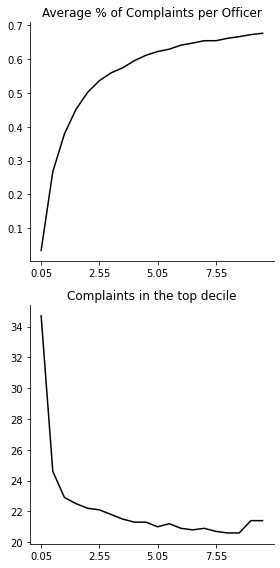

In [72]:
plt.figure(figsize = (4,8))
titles = ['Average % of Complaints per Officer', 'Complaints in the top decile']
for i,pl in enumerate([average_complaints, decile_responsible]):
    plt.subplot(2,1,i+1)
    plt.plot(pl, color = 'black')
    
    plt.xticks(np.arange(len(pl))[::5],np.arange(0.05, 10, 0.5)[::5])
    plt.title(titles[i])
    sns.despine()
plt.tight_layout()